In [236]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Am I the A-hole? A moral classification 

## Getting data through Reddit API

<details><summary><u>Reddit Scrapper</u></summary>
<p>

```python

import requests
app_id = 'appid'
secret = 'secret'
auth = requests.auth.HTTPBasicAuth(app_id, secret)

headers = {'User-Agent': 'Tutorial2/0.0.1'}
res = requests.post('https://www.reddit.com/api/v1/access_token',
auth=auth, data=data, headers=headers)

token = res.json()['access_token']
headers['Authorization'] = 'bearer {}'.format(token)
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

token = ""
api = 'https://oauth.reddit.com'
res = requests.get('{}/r/AITAFiltered/new'.format(api), headers=headers, params={'limit': '50000'})
result = res.json()

```
</p>
</details>

The result is saved as json file for further analysis

## Loading the data

In [9]:
import json
with open('aita_top_posts.json') as f:
    json_data = f.read()
    aita = json.loads(json_data)

In [10]:
import pandas as pd
df = pd.DataFrame({'title':[],'text':[],'verdict' : []})
for i in range(2,len(aita)):
    try:
        df.loc[i,['title','text','verdict']]=  [aita[i]['title'],aita[i]['crosspost_parent_list'][0]['selftext'],
                                    aita[i]['crosspost_parent_list'][0]['link_flair_text']]
    except:
        pass 
df = df[df.text != '[deleted]']

In [11]:
df = df[df.verdict != 'Not enough info']

## Cleaning and pre-processing

Checking distribution across values

<AxesSubplot:xlabel='verdict', ylabel='count'>

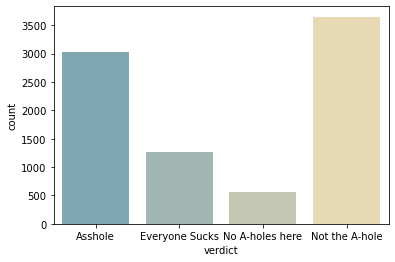

In [12]:
import seaborn as sns
sns.countplot(x = 'verdict', data = df, palette = "blend:#7AB,#EDA")

As we can see, there is some slight imbalance between Not the A-hole and other categories. Furtheremore, we just want Asshole or not A-hole. So, I'm going to group Everyone sucks with Asshole (because the poster is also at fault here) and No A-holes here with Not the A-hole (beacause the poster is not at fault here).

<AxesSubplot:xlabel='verdict', ylabel='count'>

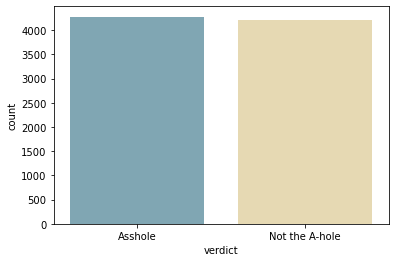

In [13]:
df.loc[df['verdict'] == 'Everyone Sucks', 'verdict'] = 'Asshole'
df.loc[df['verdict'] == 'No A-holes here', 'verdict'] = 'Not the A-hole'
sns.countplot(x = 'verdict', data = df, palette = "blend:#7AB,#EDA")

After grouping, we have a really nice distribution between two classes. 

### Text cleaning and Preprocessing

In [14]:
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import opinion_lexicon
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords
stop = stopwords.words('english')
import nltk.sentiment
tokenizer = RegexpTokenizer(r'\w+')

So there are two texts that I will work on: one is the tile for topic modelling. The second is the text for classification.
I use title for topic modelling because the title is more condense and straight to the point what the post is about. When done on the selftext, topic modelling picks out lots of pronouns and generic verbs like make, do, take, etc. Furthermore, topic modelling done on title takes shorter time.
#### Title

In [189]:
df['title'] = df['title'].apply(lambda x: x.replace("'m"," am"))
df['title'] = df['title'].apply(lambda x: x.replace("n't"," not"))
df['title'] = df['title'].apply(lambda x: x.replace("'ve"," have"))
df['title'] = df['title'].apply(lambda x: x.replace("'s"," is"))
df['title'] = df['title'].apply(lambda x: x.replace("aita"," "))
df['title'] = df['title'].apply(lambda x: x.replace("'re"," are"))
df.title = df.title.apply(lambda x: x.replace("AITA"," "))
df.title = df.title.apply(lambda x: x.replace("WIBTA"," "))
df.title = df.title.apply(lambda x: x.replace("for",""))


/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [190]:
df.title  = df.title.apply(remove_stopwords)
df

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,title,text,verdict,title_tokenized
2,break patient confidentiality tell friend boyf...,This has been eating me up inside for the past...,Asshole,"[break, patient, confidentiality, tell, friend..."
3,lose pet owner pay advertise reward ?,This weekend I was walking through the park an...,Everyone Sucks,"[keep, lose, pet, owner, pay, advertise, reward]"
5,let husband funeral baby conceive Mistress ?,This is extremely difficult to talk about with...,No A-holes here,"[let, husband, funeral, baby, conceive, mistress]"
6,piss parent Athens Georgia instead Athens Gree...,I'm 17f always wanted to go to Greece. I lov...,Not the A-hole,"[piss, parent, take, athens, georgia, instead,..."
7,refuse use word `` pregnant `` I tell people w...,"I know this is a weird hang up, but I was rais...",Asshole,"[refuse, use, word, pregnant, i, tell, people,..."
...,...,...,...,...
9994,refuse turn Kanye West GF ’ s friend request I,This is sort of a petty squabble I had but my ...,Asshole,"[refuse, turn, kanye, west, gf, s, friend, req..."
9995,suggest wife ’ t wear certain leggings ?,Backstory- we live in a low income area and th...,Asshole,"[suggest, wife, doesn, t, wear, certain, leggi..."
9996,tell sister leave angry kid loud noise MY home,My little sister and I live in the same city. ...,Not the A-hole,"[tell, sister, leave, get, angry, kid, make, l..."
9997,I wo test blood possibly help sister ?,"I'M 21, SHE IS 23!\n\nSorry if that title soun...",Not the A-hole,"[i, wo, test, blood, possibly, help, sister]"


In [191]:
tokenizer = RegexpTokenizer(r'\w+')
df['title_tokenized'] = df['title'].apply(lambda x: tokenizer.tokenize(x.lower()))

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [15]:
binarized_df = pd.get_dummies(df['verdict'])
df = pd.concat([df, binarized_df], axis=1)


In [202]:
from sklearn.feature_extraction.text import CountVectorizer
transformer = CountVectorizer()
vect = transformer.fit(df['text'])
#print(len(vect.vocabulary_))
#print(len(vect.get_feature_names()))
#transform all dataset
data_transform = vect.transform(df['text'])

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [203]:
#apply tfidf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_trans = TfidfTransformer()
tfit = tfidf_trans.fit(data_transform)
data_tfidf = tfit.transform(data_transform)

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Topic Modelling

In [135]:
df['tokens'] = df['tokenized'].apply(lambda x: tokenizer.tokenize(x.lower()))

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [192]:
from gensim import corpora
from gensim import models

aitadict = corpora.Dictionary(df.title_tokenized.tolist())
aitacorp = [aitadict.doc2bow(x) for x in df.title_tokenized.tolist()]

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [193]:
import gensim
from gensim import models

aitamodel = gensim.models.ldamodel.LdaModel(corpus=aitacorp,id2word=aitadict,
num_topics=10, passes = 10)

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [194]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
visual =  gensimvis.prepare(aitamodel, aitacorp, aitadict)
pyLDAvis.enable_notebook()
pyLDAvis.display(visual)

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



## Classification

In [201]:
df.to_csv('aita.csv', index=False)

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from textblob import TextBlob
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import re


In [17]:
def text_preprocessor(text):
    return " ".join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?#", " ", text.lower()).split())

df['processed_text'] = df['text'].apply(lambda x: text_preprocessor(x))

In [19]:
from sklearn.model_selection import train_test_split
ASS_train, ASS_test, label_train, label_test = train_test_split(df['text'], df['Asshole'], test_size=0.2, random_state=1)
from sklearn.naive_bayes import GaussianNB

### Naive Bayes

#### MultinomialNB

In [24]:
from sklearn.naive_bayes import MultinomialNB
pipelineMNB = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor)),
    ('tfidf',TfidfTransformer()),
    ('clf', MultinomialNB())
])
# Fit the pipeline to the ASS_training data
pipelineMNB.fit(ASS_train, label_train)
# Make predictions on the test data
predictions = pipelineMNB.predict(ASS_test)
# Print classification report
print(classification_report(label_test, predictions))


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       910
           1       0.99      0.86      0.92       848

    accuracy                           0.93      1758
   macro avg       0.94      0.93      0.93      1758
weighted avg       0.94      0.93      0.93      1758



### Support Vector Classification


In [249]:
# Support Vector Classification
# Support Vector Classification
pipeline_svc = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor)),
    ('tfidf',TfidfTransformer()),
    ('clf', SVC(kernel='linear', C=2.0))
])

# Fit the pipeline to the training data
pipeline_svc.fit(ASS_train, label_train)

# Make predictions on the test data
predictions_svc = pipeline_svc.predict(ASS_test)
# Set the range of hyperparameter values to search over
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'clf__C': [0.1, 1, 10]
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline_svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(ASS_train, label_train)

# Print the best hyperparameters and the corresponding accuracy score on the validation set
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Make predictions on the test set using the best hyperparameters
best_pipeline = grid_search.best_estimator_
predictions = best_pipeline.predict(ASS_test)
accuracy = accuracy_score(label_test, predictions)
print("Test accuracy:", accuracy)


/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'clf__C': 1, 'vect__max_df': 0.5}
Best score: 0.9398391096741451
Test accuracy: 0.9334470989761092


In [20]:
# Define the pipeline
pipeline_svc = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor, max_df=0.5)),
    ('tfidf',TfidfTransformer()),
    ('clf', SVC(kernel='linear', C=1))
])

# Fit the pipeline to the ASS_training data
pipeline_svc.fit(ASS_train, label_train)

# Make predictions on the test data
predictions_svc = pipeline_svc.predict(ASS_test)

# Print confusion matrix
print(confusion_matrix(label_test, predictions_svc))

# Compute accuracy score
accuracy = accuracy_score(label_test, predictions_svc)
print("Test accuracy:", accuracy)

[[910   0]
 [117 731]]
Test accuracy: 0.9334470989761092


### Random Forest

In [247]:
# Set the range of hyperparameter values to search over
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor,ngram_range=(1, 2))),
    ('tfidf',TfidfTransformer()),
    ('clf', RandomForestClassifier(max_depth=990))
])
param_grid = {
    'clf__max_depth': range(990,1000)
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(ASS_train, label_train)

# Print the best hyperparameters and the corresponding accuracy score on the validation set
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Best parameters: {'clf__max_depth': 990}
Best score: 0.9398391096741451


In [250]:
# Random forrest Classifier with hyperparameter
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor,ngram_range=(1, 2))),
    ('tfidf',TfidfTransformer()),
    ('clf', RandomForestClassifier(max_depth=990))
])
# Fit the pipeline to the ASS_training data
pipeline_rf.fit(ASS_train, label_train)

# Make predictions on the test data
predictions_rf = pipeline_rf.predict(ASS_test)
# Print accuracy score
print("Accuracy:", accuracy_score(label_test, predictions_rf))

/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy: 0.9334470989761092


#### Logistic Regression

In [246]:
# Logistic Regression Classifier
pipeline_l = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor)),
    ('tfidf',TfidfTransformer()),
    ('clf', LogisticRegression())
])

# Fit the pipeline to the ASS_training data
pipeline_l.fit(ASS_train, label_train)

# Make predictions on the test data
predictions_l = pipeline_l.predict(ASS_test)
# Print accuracy score
print("Accuracy:", accuracy_score(label_test, predictions_l))
# Print confusion matrix
print(confusion_matrix(label_test, predictions_l))


/Users/duongton/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Accuracy: 0.9334470989761092
[[910   0]
 [117 731]]


#### Neural Net

In [25]:
from sklearn.linear_model import Perceptron

# Build the pipeline with Perceptron classifier and TF-IDF transformation

pipeline_perc = Pipeline([
    ('vect', CountVectorizer(preprocessor=text_preprocessor)),
    ('tfidf', TfidfTransformer()),
    ('clf', Perceptron())
])

# Fit the pipeline to the ASS_training data
pipeline_perc.fit(ASS_train, label_train)

# Make predictions on the test data
predictions_perc = pipeline_perc.predict(ASS_test)
# Print accuracy score
print("Accuracy:", accuracy_score(label_test, predictions_perc))
# Print confusion matrix
print(confusion_matrix(label_test, predictions_perc))

NameError: name 'pipeline_perc' is not defined

NB

## Demo

In [33]:
def show(text):
    a = []
    a.append(text)
    #if pipeline_rf.predict(a)[0]==1:
    #if pipelineMNB.predict(a)[0]==1:
    if pipeline_svc.predict(a)[0]==1:
        b = "You are the asshole"
    else:
        b = "You're not the asshole"
    return b

In [35]:
import gradio as gr
iface = gr.Interface(fn=show, inputs="text", outputs="text")
iface.launch(share = True)

Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://ec68f5055d4443c182.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
